# Klaszterezés és az EM algoritmus

**Emlékeztető.** Tegyük fel, hogy a modellünkben van megfigyelt és rejtett változó is. Ez a modell illesztését nagyon megnehezíti, hiszen

\begin{align}
p(x|\theta) = \int p(x,z|\theta) dz, 
\end{align}

ahol $x$ a megfigyelt változó, $z$ rejtett, $\theta$ a $p$ eloszlás paraméterezése. Azaz nemcsak, hogy $z$ eloszlásáról kell nyilatkoznunk (ez még menne), hanem várható értéket is kell számolni vele; ez az integrál azonban rendszerint nem megoldható. Szerencsére jó közelítés még így is adható. Láttuk, hogy a $p(x|\theta)$ eloszlást a következőképpen dekomponálhatjuk:

\begin{align}
\ln p(x|\theta) = \int q(z) \ln \frac{p(x,z|\theta)}{q(z)} dz - \int q(z) \ln \frac{p(z|x,\theta)}{q(z)} dz = \mathcal{L}[q] + KL(q||p) ,
\end{align}

ahol $\mathcal{L}[q]$ az alsó korlát (ELBO) és $KL(q||p)$ a KL-divergencia. Korábban, a varációs módszereknél olyan $q(z)$-t kerestünk, amelyik KL értelemben jól közelíti a $p(z|x,\theta)$ feltételes eloszlást; ezt úgy értük el, hogy az előbbi egyenletben az ELBO-t maximalizáltuk $q \in \mathcal{Q}$ szerint (innen a "variációs" megnevezés). Mivel a bal oldal fix, ez szükségszerűen a KL-divergencia csökkenését, azaz a közelítés javulását eredményezi. Ehhez igyekeztünk olyan $\mathcal{Q}$ függvényosztályt találni, ami elég tág ahhoz, hogy jó közelítést kapjunk. Tipikusan, $q$-t egy mély neurális hálózat adta (pl. VAE).

Most más megközelítést választunk, megkötjük $q$ alakját. Szerencsére $q$ (adott $\hat \theta$ melletti!) optimális alakját könnyen meghatározhatjuk, hiszen a KL-divergencia akkor minimális, ha

\begin{align}
q(z) := p(z|x,\hat \theta),
\end{align}

ahol $\hat \theta$ azt sugallja, hogy itt $\theta$-nak egyfajta iteratív frissítéséről lesz szó (másképpen, maximum likelihood megoldást keresünk). Behelyettesítve az ELBO-ba, és csak a $\theta$-t tartalmazó tagot megtartva:

\begin{align}
\mathcal{L}[q] &= \int p(z|x,\hat\theta) \ln \frac{p(x,z|\theta)}{p(z|x,\hat\theta)} dz \\
 &= \int p(z|x,\hat\theta) \ln p(x,z|\theta) dz + const. \\
 &= E_{p(z|x,\hat\theta)} \left[\ln p(x,z|\theta) \right] + const.
\end{align}

A következő iteratív sémához jutottunk:
- E-lépés (expectation): $\hat\theta$-t fixen tartva meghatározzuk $q(z) = p(z|x,\hat\theta)$ és az $\mathcal{L}[q]$ várható értéket.
- M-lépés (maximization): $q$-t fixen tartva maximalizáljuk $\mathcal{L}$-t $\theta$ szerint (ő lesz az új $\hat\theta$).

Ez az EM algoritmus lényege. Látjuk, hogy mindkét lépés növeli az ELBO-t, tehát tényleg maximum likelihood megoldást fogunk találni.

**E-lépés Gauss keverék-eloszlásokra.** Legyenek adottak az $\mathbf{x}_i \in \mathbb{R}^d$ alakú adatpontok, és tegyük fel a következő valószínűségi modellt:

\begin{align}
p(z_i | \pi) &= \mathcal{C}at(z_i | \pi) = \prod_k \pi_k^{z_{ik}}, \\
p(\mathbf{x}_i | z_i,\mu,\Sigma) &= \prod_k \mathcal{N}(\mathbf{x}_i | \mu_k,\Sigma_k)^{z_{ik}},
\end{align}

ahol $z_i$ one-hot módon kódolt és $\sum_k \pi_k = 1$. Az ilyen eloszlásokat nevezzük Gauss keverék-eloszlásnak, hiszen

\begin{align}
p(\mathbf{x}_i | \mu,\Sigma,\pi) = \sum_{z_i} p(\mathbf{x}_i | z_i,\mu,\Sigma) p(z_i | \pi) = \sum_k \pi_k \mathcal{N}(\mathbf{x}_i | \mu_k,\Sigma_k) .
\end{align}

Ezzel lényegében azt mondjuk, hogy minden $\mathbf{x}_i$ adatpont a $K$ darab Gauss-eloszlás valamelyikéből jön. A keverék-eloszlás komponensei felelnek meg a klasztereknek, és minden klaszternek van egy $\mu_k$ várható értéke és egy $\Sigma_k$ kovarianciamátrixa. A célunk, hogy megtaláljuk a klaszterek középpontjait és "kiterjedését", azaz maximum likelihood becslést fogunk végezni a $\pi$, $\mu$, $\Sigma$ paraméterekre az EM algoritmussal. Kiszámítjuk az ehhez szükséges mennyiségeket az összes adatpontra ($\theta$ most értelemszerűen három paraméterre bomlik):

\begin{align}
\ln p(\mathbf{X},\mathbf{Z} | \pi,\mu,\Sigma) &= \sum_i \ln p(\mathbf{x}_i | z_i,\mu,\Sigma) + \ln p(z_i | \pi) = \sum_i \sum_k z_{ik} \left( \ln \pi_k + \ln \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k ) \right) , \\
p(\mathbf{Z} | \mathbf{X}, \pi,\mu,\Sigma) &\propto p(\mathbf{X} | \mathbf{Z}, \mu,\Sigma) p(\mathbf{Z} | \pi) = \prod_i \prod_k \pi_k^{z_{ik}}\mathcal{N}(\mathbf{x}_i | \mu_k,\Sigma_k)^{z_{ik}}.
\end{align}

Majd kiszámítjuk az EM algoritmusban használt várható értéket:

\begin{align}
E_{p(\mathbf{Z} | \mathbf{X}, \pi,\mu,\Sigma)} \left[ \ln p(\mathbf{X},\mathbf{Z} | \pi,\mu,\Sigma) \right] &= \sum_i \sum_k E_{p(\mathbf{Z} | \mathbf{X}, \pi,\mu,\Sigma)}\left[z_{ik}\right] \left( \ln \pi_k + \ln \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k ) \right) \\
E_{p(\mathbf{Z} | \mathbf{X}, \pi,\mu,\Sigma)}\left[z_{ik}\right] &= \sum_{z_{ik}} z_{ik} p(z_{ik} | \mathbf{x}_i, \pi_k,\mu_k,\Sigma_k) \\
&= \sum_{z_{ik}} z_{ik} \frac{p(\mathbf{x}_i | z_{ik}, \mu_k, \Sigma_k) p(z_{ik} | \pi_k)}{p(\mathbf{x}_i | \mu, \Sigma,\pi)} \\
&= \frac{\pi_k \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k)}{\sum_k \pi_k \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k)} =: \gamma_{ik} .
\end{align}

Ha jobban megnézzük, utóbbinak szemléletes jelentése is van: a $k$. klaszter mennyiben "felelős" az $\mathbf{x}_i$ pontért (intuitíve: a beletartozások valószínűségeinek arányában). Összesítve az ELBO:

\begin{align}
\mathcal{L} (\pi,\mu,\Sigma) = \sum_i \sum_k \gamma_{ik} \left( \ln \pi_k + \ln \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k ) \right) .
\end{align}

**M-lépés Gauss keverék-eloszlásokra.** Az M lépésben rögzítjük $\gamma_{ik}$-t, és maximalizáljuk az ELBO-t $\pi$, $\mu$ és $\Sigma$ szerint. Vegyük először $\mu_k$ szerint:

\begin{align}
\nabla_{\mu_k} \mathcal{L} &= -\sum_i \gamma_{ik} \Sigma_k^{-1} (\mathbf{x}_i-\mu_k) = 0 \\
&\Rightarrow \mu_k = \frac{1}{N_k} \sum_i \gamma_{ik} \mathbf{x}_i ,\quad N_k = \sum_i \gamma_{ik}
\end{align}

ahol szintén találunk szemléletes jelentést: $\mu_k$ a $k$. klaszterbe tartozó pontok súlyozott átlaga, ahol a "beletartozás" mértéke adja a súlyt. Hasonlóképpen $\Sigma_k$-ra

\begin{align}
\Sigma_k = \frac{1}{N_k} \sum_i \gamma_{ik} (\mathbf{x}_i-\mu_k)(\mathbf{x}_i-\mu_k)^T
\end{align}

adódik. Végül $\pi_k$-ra

\begin{align}
\max_{\pi_k} &\quad \sum_i \gamma_{ik} \ln \pi_k \\
s.t. &\quad \sum_k \pi_k = 1,
\end{align}

ahol a Lagrange-dualitást felhasználva

\begin{align}
L(\pi_k,\mu) &= \sum_i \gamma_{ik} \ln \pi_k + \mu \left(\sum_k \pi_k - 1 \right), \\
\frac{\partial L}{\partial \pi_k} &= \frac{N_k}{\pi_k} + \mu = 0, \\
 &\Rightarrow \pi_k = - \frac{N_k}{\mu}.
\end{align}

Utóbbit $k$ szerint szummázva

\begin{align}
1 = \frac{-\sum_k {N_k}}{\mu} \Rightarrow \mu = - \sum_k N_k = - N \Rightarrow \pi_k = \frac{N_k}{N},
\end{align}

ahol $N$ egyben a mintahalmaz mérete.

**Összefoglalás.** Az EM algoritmus Gauss keverék eloszlásokra a következő:

0. Inicializáció véletlen $\mu$, $\Sigma$ és $\pi$ paraméterekkel.
1. E-lépés: $\gamma_{ik} = \frac{\pi_k \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k)}{\sum_k \pi_k \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k)}$, $N_k = \sum_i \gamma_{ik}$.
2. M-lépés: $\mu_k = \frac{1}{N_k} \sum_i \gamma_{ik} \mathbf{x}_i$, $\Sigma_k = \frac{1}{N_k} \sum_i \gamma_{ik} (\mathbf{x}_i-\mu_k)(\mathbf{x}_i-\mu_k)^T$, $\pi_k = \frac{N_k}{N}$.
3. Ismétlés.

In [1]:
%pylab inline

from scipy.stats import multivariate_normal

Populating the interactive namespace from numpy and matplotlib


**0. feladat.** A lenti kóddal generáljon és ábrázoljon egy adathalmazt.

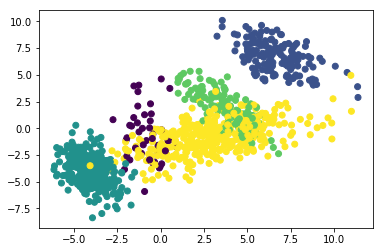

In [2]:
def generate_data(N,K):
  mu,sg = [],[]
  for k in range(K):
    mu += [np.random.randn(2)*5]
    ss = np.random.randn(2,2)
    sg += [ss.T@ss + np.eye(2)/2]

  pi = np.random.rand(K)
  pi = pi/sum(pi)
  X,Z = [],[]
  for i in range(N):
    k = np.random.choice(np.arange(K),p=pi)
    X += [multivariate_normal.rvs(mu[k],sg[k])]
    Z += [k]
  X = np.row_stack(X)
  return X,Z,np.vstack(mu),sg,pi

X,Z_,mu_,sg_,pi_ = generate_data(1000,5)
scatter(X[:,0],X[:,1],c=Z_);

**1. feladat.** Implementálja a fenti algoritmust! Törekedjen az egyszerűségre, a feladat kb. 15 sorból megoldható. Külső csomagot ne használjon (ez alól a `multivariate_normal.pdf()` függvény kivétel, ezt érdemes is beépíteni a megoldásba).

In [3]:
def EMclust(K,X,iter):
  D   = X.shape[1]
  mu  = np.random.randn(K,D)
  sg  = [np.eye(D) for k in range(K)]
  pi  = np.ones(K)/K

  for i in range(iter):
    G = np.column_stack([pi[k]*multivariate_normal.pdf(X,mean=mu[k],cov=sg[k]) for k in range(K)])
    G = G/np.expand_dims(np.sum(G,axis=1),1)
    N = np.sum(G,axis=0)

    for k in range(K):
        d = X-mu[k]
        sg[k] = d.T@(d*np.expand_dims(G[:,k],1)) / N[k]
    mu = G.T@X / np.expand_dims(N,1)

    pi = N/np.sum(N)
  Z = np.argmax(G,axis=1)
  return mu,sg,pi,Z

**2. feladat.** Ábrázolja a kiakakuló klasztereket! Az ábrán jelenjenek meg a pontok (klaszterenként különböző színekkel), valamint az illesztett komponensek szintvonalai.

In [4]:
def EMplot(X,Z,mu,sg,pi):
  K = len(mu)
  scatter(X[:,0],X[:,1],c=Z)
  scatter(mu[:,0],mu[:,1],c='r');

  tx,ty = np.meshgrid(np.linspace(np.min(X[:,0]),np.max(X[:,0]),100),np.linspace(np.min(X[:,1]),np.max(X[:,1]),100))
  Xt = np.vstack((tx.flatten(),ty.flatten())).T
  Gt = np.column_stack([pi[k]*multivariate_normal.pdf(Xt,mean=mu[k],cov=sg[k]) for k in range(K)])
  for k in range(K):
      contour(tx,ty,Gt[:,k].reshape(100,100),colors='r')

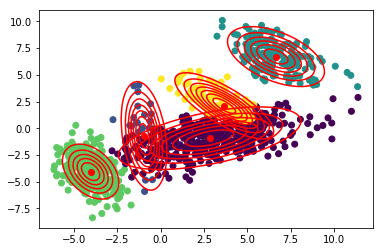

In [5]:
mu,sg,pi,Z = EMclust(5,X,1000)
EMplot(X,Z,mu,sg,pi)

**3. feladat.** Értékelje ki a megoldást a következők alapján:

- Prediktált és valódi klaszterezés együttjárása (`sklearn.metrics.adjusted_rand_score`)
- Klaszterközéppontok eltérése a valódi klaszterközéppontoktól (plot)

A kiértékelést végezze el több véletlenszerűen generált adathalmazon is. Mit tapasztalt?